In [1]:
from collections import defaultdict
from copy import deepcopy
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import re
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import spacy
from typing import Callable, Dict, List, Optional, Set, Tuple

In [36]:
def get_arg_max_real(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if np.real(x[i])> M:
            M = np.real(x[i])
            index=i
    return index

def get_arg_max_modulus(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if x[i]>= M:
            M = x[i]
            index=i
    return index

def get_leading_eigenvector(B):
    [vals,vecs] = np.linalg.eig(B)
    # If no positive eigenvalues, to within round off error
    if all(v < 1e-4 for v in list(vals)): 
        ones = np.ones((1,len(B))) / np.sqrt(len(B)) # Normalized vector of all 1's
        max_vec = ones[0,:]
    else:
        arg_max = get_arg_max_real(vals)
        max_vec = np.real(vecs[:,arg_max])
    return max_vec

def get_principal_eigenvector(A):
    [vals,vecs] = np.linalg.eig(A)
    arg_max = get_arg_max_modulus(vals)
    max_vec = vecs[:,arg_max]
    return max_vec

def get_shores_from_eigenvector(nodes,x):
    shore1 = set()
    shore2 = set()
    for node in nodes:
        if x[node] < 0: shore1.add(node)
        else: shore2.add(node)
    return [shore1, shore2]

def get_two_fiedler_eigenvectors(L):
    [evals, evecs] = np.linalg.eig(L)
    sorted_indices = np.argsort(evals)
    two_smallest_nonzero = []
    for i in sorted_indices:
        if evals[i] ==0: continue
        two_smallest_nonzero.append(i)
        if len(two_smallest_nonzero) == 2: break
    print(two_smallest_nonzero)
    fiedler1 = evecs[:,two_smallest_nonzero[0]]
    fiedler2 = evecs[:,two_smallest_nonzero[1]]
    return fiedler1, fiedler2

def get_largest_vectors(A):
    [evals, evecs] = np.linalg.eig(A)
    evals = [0 if np.abs(v) < 1e-5 else np.round(np.abs(v),1) for v in evals]
    sorted_indices = np.argsort(evals)
    two_largest_nonzero = []
    for i in np.flip(sorted_indices):
        two_largest_nonzero.append(i)
        if len(two_largest_nonzero) == 2: break
    big1 = np.real(evecs[:,two_largest_nonzero[0]])
    big2 = np.real(evecs[:,two_largest_nonzero[1]])
    return big1, big2

def form_encoding(vector1, vector2):
    z = np.zeros((len(vector1),2))
    for i in range(len(vector1)):
        z[i,0] = vector1[i]
        z[i,1] = vector2[i]
    return z

def get_clusters(embedding, num_clusters=4):
    kmeans = KMeans(
        init="random",
        n_clusters=num_clusters,
        n_init=10,
        random_state=1234
        )
    kmeans.fit(embedding)
    return kmeans

def get_colors_from_clusters(embedding, num_clusters = 4):
    kmeans = get_clusters(embedding, num_clusters=num_clusters)
    labels = kmeans.labels_
    color_template = ['y', 'c', 'm', 'k', 'red', 'green', 'lightblue']
    color = [color_template[x] for x in list(labels) ]
    return color

class graphHandler:
    def __init__(self, G, colormap, use_pydot = True):
        # self.G = nx.convert_node_labels_to_integers(G)
        self.G = G
        self.color_template = self.color_template = ['y', 'b', 'm', 'c', 'k'] 
        self.color_map = colormap
        if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')
        else: self.pos = nx.nx_agraph.graphviz_layout(self.G,prog='neato')
    ####################
    ## Public methods ##
    ####################
    def getGraph(self): return self.G
    def showGraph(self,agent_colors = None,title = None, with_labels = False, legend = None):
        if agent_colors == None: agent_colors = self.color_map
        if title == None: title = "Network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        if with_labels:
            nx.draw(self.G,self.pos,node_color = agent_colors, with_labels = with_labels, node_size = 200, alpha=0.8)
        else:
            nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
        if legend is not None:
            plt.legend(handles = legend, loc = 'best')
        plt.show()
    def showLouvainCommunities(self, title = None):
        agent_colors = self._getAgentColors_from_LouvainCommunities()
        if title == None: title = "Louvain communities for network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
    def showDendrogram(self):
        myHandler = DendrogramHandler(self.G)
        Z = myHandler.getLinkMatrix()
        ZLabels = myHandler.getLinkMatrixLabels()
        #plt.figure(figureNumber);plt.clf()
        dendrogram(Z, labels=ZLabels)
        del myHandler
    def show_kCores(self):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # compute position of each node with shell layout
        nlist = []
        for k in sorted(kcores.keys(),reverse=True):
            nlist.append(kcores[k])
        pos = nx.layout.shell_layout(self.G, nlist = nlist)
        colors = ['black','lightblue','yellow','magenta','olive', 'cyan', 'red']
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(list(kcores.keys()),reverse = True):
            nodes = kcores[kcore]
            color = colors[kcore%len(colors)]
            nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=color)
            label = f"kcore = {kcore}"
            legend_elements.append(Line2D([0], [0], marker='o', color=color, label=label,markerfacecolor=color, markersize=15))
        nx.draw_networkx_edges(self.G, pos, width=0.2)
        nx.draw_networkx_labels(self.G, pos)
        plt.title("K-core layout of network")
        plt.legend(handles = legend_elements, loc = 'best')

    def show_kCores_by_partition(self, colors, title = "K-core of Network"):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # Shapes
        shapes = ["o", "v", "s", "*", "+", "d"]

        # compute position of each node with shell layout
        nlist = []
        for k in sorted(kcores.keys(),reverse=True):
            nlist.append(kcores[k])
        pos = nx.layout.shell_layout(self.G, nlist = nlist)
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(kcores.keys(),reverse=True):
            nodes = kcores[kcore]
            shape = shapes[kcore%len(shapes)]
            
            #nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=colors[nodes[0]], node_shape=shape, alpha = 0.5, node_size=90)
            for node in nodes:
                nx.draw_networkx_nodes(self.G, pos, nodelist=[node], node_color=colors[node], node_shape=shape, alpha = 0.5, node_size=90)
            label = f"kcore = {kcore}"
            legend_elements.append(Line2D([0], [0], marker=shape, color='k', markerfacecolor = 'w', label=label, markersize=10))
        
        nx.draw_networkx_edges(self.G, pos, width=0.1)
        #nx.draw_networkx_labels(self.G, pos)
        plt.title(title)
        plt.legend(handles = legend_elements, loc = 'best')

    def show_partitions(self, partition_list, title = "Network colored by partitions"):
        plt.figure()
        plt.axis('off')
        for i in range(len(partition_list)):
            nx.draw_networkx_nodes(partition_list[i],self.pos,node_color=self.color_template[i%len(self.color_template)], alpha = 0.8)
        for edge in self.G.edges:
            self._draw_edge_by_type(edge, partition_list)
        nx.draw_networkx_labels(self.G,self.pos)
        if len(partition_list) == 0:
            mod = 0
        else:
            mod = nx.algorithms.community.quality.modularity(self.G,partition_list)
        title = title + ": Modularity = " + str(np.round(mod,2))
        plt.title(title)
    
    #####################
    ## Private methods ##
    #####################
    def _getAgentColors_from_LouvainCommunities(self):
        """ Use the Louvain partition method to break the graph into communities """
        # Louvain method pip install python-louvain
        # see https://arxiv.org/pdf/0803.0476.pdf
        # see https://github.com/taynaud/python-louvain
        color_map = self.color_map
        set_of_partitions = nx.community.louvain_communities(self.G)
        print(f"The Louvain algorithm found {len(set_of_partitions)} partitions.")
        partition_number = 0
        for partition in set_of_partitions:
            print(f"Partition {partition_number} is {partition}")
            for node in partition:
                color_map[node] = self.color_template[partition_number%len(self.color_template)]
            partition_number += 1
        return color_map
    def _draw_edge_by_type(self, edge, partition):
        edge_style = 'dashed'
        for part in partition:
            if edge[0] in part and edge[1] in part:
                edge_style = 'solid'
                break
        nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)

def read_data(folder_path: str = './final_project_files') -> Tuple[pd.DataFrame, pd.DataFrame]:
    nodes_file = f'{folder_path}/nodes.csv'
    edges_file =  f'{folder_path}/edges.csv'
    nodes_data = pd.read_csv(nodes_file)
    edges_data = pd.read_csv(edges_file)
    
    return nodes_data, edges_data

def create_graph(nodes_data: pd.DataFrame, edges_data: pd.DataFrame, show_graph: bool = False) -> graphHandler:
    # Use nodes and edges to create the graph
    G = nx.Graph()
    message_node_id = nodes_data['node'].max()
    message_node_types, message_node_values = {}, {}

    for i in nodes_data.index:
        source, target = edges_data['source'][i], edges_data['target'][i]
        edge_type, content = edges_data['edge_type'][i], edges_data['content'][i]

        if source != target: # Don't include self loops
            # Don't add a message node if the edge represents a thread in a channel
            if edge_type == 'thread_in_channel':
                G.add_edge(source, target, **{'edge_type': 'thread_in_channel'})

            # Otherwise, add a message node
            else:
                message_node_id += 1
                message_edge_type = 'message_in_channel' if edge_type == 'posted_in_channel' else ('message_in_thread' if edge_type == 'posted_in_thread' else 'message_to')
                G.add_edge(source, message_node_id, **{'edge_type': 'posted_message'})
                G.add_edge(message_node_id, target, **{'edge_type': message_edge_type})
                message_node_types[message_node_id] = 'message'
                message_node_values[message_node_id] = content


    # Add node types and values
    node_type_dict = {nodes_data['node'][i]: nodes_data['type'][i] for i in nodes_data.index}
    node_value_dict = {nodes_data['node'][i]: nodes_data['value'][i] for i in nodes_data.index}
    nx.set_node_attributes(G, node_type_dict, 'node_type')
    nx.set_node_attributes(G, message_node_types, 'node_type')
    nx.set_node_attributes(G, node_value_dict, 'node_value')
    nx.set_node_attributes(G, message_node_values, 'node_value')

    # Wrap the graph in a graph handler (gives us extra functionality)
    graph_handler = graphHandler(G, ['y' for _ in G.nodes], use_pydot=False)

    if show_graph:
        colors = []
        H = graph_handler.getGraph() # Get graph sorted by value
        color_map = ['y', 'm', 'c', 'b', 'g', 'k']
        types = list(set(list(node_type_dict.values()) + ['message']))
        type_colors = {types[i]: color_map[i%len(color_map)] for i in range(len(types))}
        legend_elements = []

        for node_type in type_colors.keys():
            legend_elements.append(Line2D([0], [0], marker='o', color=type_colors[node_type], markerfacecolor = type_colors[node_type], label=node_type, markersize=10))

        for node in H.nodes:
            colors.append(type_colors[G.nodes[node]['node_type']])

        graph_handler.showGraph(title='CS 236 Discord Graph', agent_colors=colors, legend=legend_elements)

    return graph_handler

# Projection 1
def remove_nodes(handler: graphHandler, node_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    # If we're removing messages, add edges between people and the message destination first - some or all of the destinations 
    # might be removed later in the projection, but that's ok
    if 'message' in node_types_to_remove:
        for u, v in graph_copy.edges:
            if graph_copy.nodes[u]['node_type'] == 'person' and graph_copy.nodes[v]['node_type'] == 'message':
                message_neighbors = list(graph_copy.neighbors(v))
                assert len(message_neighbors) == 2  # A message should only go to another person, a channel, or a thread
                message_neighbor = message_neighbors[0] if message_neighbors[0] != u else message_neighbors[1]
                assert message_neighbor != u
                message_neighbor_type = graph_copy.nodes[message_neighbor]['node_type']
                new_edge_type = 'replied_to' if message_neighbor_type == 'person' else ('posted_in_channel' if message_neighbor_type == 'channel' else 'posted_in_thread')
                graph_copy.add_edge(u, message_neighbor, **{'edge_type': new_edge_type})

    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_type'] in node_types_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 1
def remove_nodes_by_value(handler: graphHandler, node_values_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_value'] in node_values_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 2
def remove_edges(handler: graphHandler, edge_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_edges_from([edge for edge in graph_copy.edges if graph_copy.nodes[edge]['edge_type'] in edge_types_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 3
def remove_singletons(handler: graphHandler) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if nx.degree(graph_copy, node) < 1])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

def show_eigenvector_communities(handler: graphHandler) -> None:
    graph = handler.getGraph()
    A = nx.adjacency_matrix(graph).toarray()
    v1, v2 = get_largest_vectors(A)
    embedding = form_encoding(v1, v2)
    colors = get_colors_from_clusters(embedding, num_clusters=3)
    plt.scatter(embedding[:,0], embedding[:,1],s=100,alpha = 0.8, color = colors)
    plt.title('Eigenvector Embeddings')
    plt.show()
    handler.showGraph(title='Eigenvector Communities', agent_colors=colors, with_labels=True)

In [20]:
# Projection 4
def add_new_relationship(handler: graphHandler, direct_relationship_edge_type: str, node_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())

    # Create bi-partite graph by removing edges that represent direct relationships
    direct_relationship_edges = []  # We'll need to add these back at the end

    for u, v, attrs in list(graph_copy.edges(data=True)):
        if attrs['edge_type'] == direct_relationship_edge_type:
            graph_copy.remove_edge(u, v)
            direct_relationship_edges.append((u, v))

    # Calculate the two-step paths matrix
    A = nx.adjacency_matrix(graph_copy).toarray()
    two_step_paths = A @ A

    # Remove self-loops
    np.fill_diagonal(two_step_paths, 0)

    # Add edges between nodes based on the two-step path matrix
    nodes = list(graph_copy.nodes())

    for i in range(len(two_step_paths)):
        for j in range(len(two_step_paths[0])):
            node_1, node_2 = nodes[i], nodes[j]

            if two_step_paths[i][j] > 0:
                graph_copy.add_edge(node_1, node_2)

    # Add back the edges that represent direct relationships
    graph_copy.add_edges_from(direct_relationship_edges)

    # Remove any unwanted nodes and singletons
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_type'] in node_types_to_remove])
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if nx.degree(graph_copy, node) < 1])

    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

In [28]:
def who_interacted_with_whom(handler: graphHandler) -> graphHandler:
    projected_graph_handler = remove_nodes(handler, set(['channel', 'message']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] != 'channel'
    projected_graph_handler = remove_singletons(projected_graph_handler)
    projected_graph_handler = add_new_relationship(projected_graph_handler, 'replied_to', set(['thread']))

    return projected_graph_handler

In [10]:
nodes_data, edges_data = read_data()

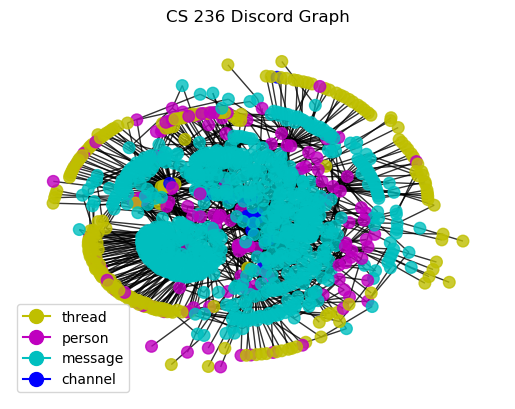

In [18]:
graph_handler = create_graph(nodes_data, edges_data, show_graph=True)

In [37]:
who_interacted_with_whom_handler = who_interacted_with_whom(graph_handler)

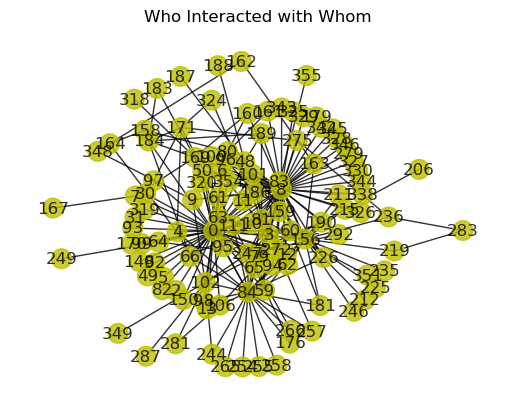

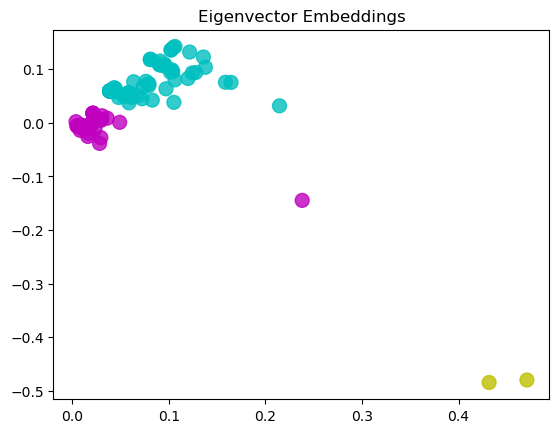

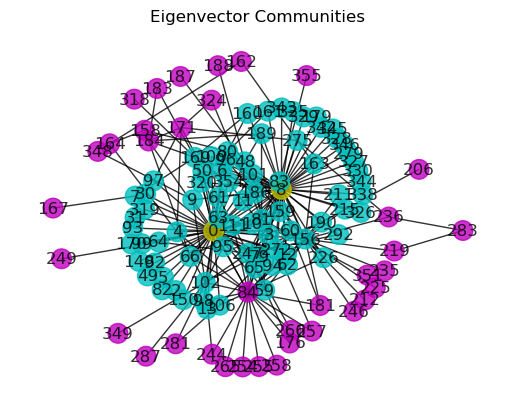

In [38]:
who_interacted_with_whom_handler.showGraph(title='Who Interacted with Whom', with_labels=True)
show_eigenvector_communities(who_interacted_with_whom_handler)